In [8]:
import torch
import torchvision

import numpy as np
from PIL import Image
import requests

In [5]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)
image.size

(640, 480)

## [Cutout - Dropout in the input space](https://arxiv.org/pdf/1708.04552.pdf)

> `Cutout` drops out a patch of image at the start, so that its features are also subsequently dropped in the network unlike `dropout` which drops features explicitly. 


This is very similar to 

> `Denoising Auto-Encoders` uses Bernoulli noise to randomly erase individual pixels in the input image, where as `context encoders` erase larger spatial region. While both models have the same goal, context encoders are more effective at representation learning, as they force the model to understand the content of the image in a global sense, rather than a local sense as denoising auto-encoders do.



## Hyperparameters.
- targeted cutout is less effect that random cutout
- size is a better parameter to tune than shape of the cutout (hence used square patches)
- number of holes is another parameter

## Approach 
- Randomly select a pixel coordinate within the image as a center point and then place the cutout mask around that location.
- Part of the patch can fall outside the image also. 
- An alternative approach that achieves similar performance is to randomly apply cutout constrained within the image region, but with 50% probability so that the network sometimes receives unmodified images.

In [6]:
class Cutout(object):
    """Randomly mask out one or more patches from an image.
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

> Some of the below code is copied from [here](https://huggingface.co/blog/annotated-diffusion)

In [30]:
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

image_size = 128
transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(), # turn into Numpy array of shape HWC, divide by 255
    Lambda(lambda t: (t * 2) - 1),
    Cutout(n_holes=8, length=8)
])

x_start = transform(image).unsqueeze(0)
x_start.shape

torch.Size([1, 3, 128, 128])

In [31]:
import numpy as np

reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

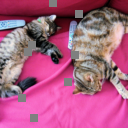

In [32]:
reverse_transform(x_start.squeeze())